In [33]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.sparse import bsr_matrix, coo_matrix
from scipy.sparse.linalg import eigs
import joblib
from joblib import Parallel, delayed
import itertools
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from tqdm import tqdm
import contextlib
import copy
import seaborn as sns

In [24]:
def construct_adjacency_matrix(X, n):
    k = X.shape[0]
    W = np.zeros((k, k))
    neigh = NearestNeighbors(n_neighbors=n+1).fit(X)
    neighbors = neigh.kneighbors(X, n_neighbors=n+1, return_distance=False)[:, 1:]
    for i in range(k):
        W[i, neighbors[i]] = 1
    W = coo_matrix(W)
    W = W + W.transpose()
    W = W.sign()
    return W

def train_and_evaluate(v, s, labels):
    E = v[:s]
    conf = []
    for label in np.unique(labels):
        Y = np.copy(labels)
        Y[labels == label] = 1
        Y[labels != label] = -1
        a = np.linalg.pinv(E) @ Y[:s]
        conf.append(np.sum(v[s:] * a, axis=1).tolist())
    conf = np.array(conf)
    pred_labels = np.argmax(conf, axis=0)
    return np.mean(pred_labels != labels[s:])

In [25]:
# load data
data = sio.loadmat("datasets/TrainImages.mat")['TrainImages']
data = data/255.0
data = data.reshape(60000, 28*28)
X = PCA(n_components=100).fit_transform(data)

labels = sio.loadmat("datasets/TrainImageLabels.mat")['Labels']
labels = np.array(labels, dtype='int').squeeze()
Y = np.copy(labels)

In [26]:
# set parameters
n = 8
p = 50
s_list = [20, 50, 100, 500, 1000, 5000, 20000, 50000]
num_reps = 1

In [27]:
# compute the adjancency matrix and the graph Laplacian
W = construct_adjacency_matrix(X, n)
d = np.array(np.sum(W, axis=1)).squeeze()
D = coo_matrix(W.shape)
D.setdiag(d)
L = D - W

In [28]:
# compute first p eigenvectors
# p = s // 5
_ , v = eigs(W, k=60)
v = np.real(v)

In [29]:
# train and evaluate
mean_error_list = []
std_error_list = []
for s in s_list:
    buffer = []
    for rep in range(num_reps):
        idx = np.random.permutation(len(v))
        buffer.append(train_and_evaluate(v[idx], s, labels[idx]))
    mean_error_list.append(np.mean(buffer))
    std_error_list.append(np.std(buffer))

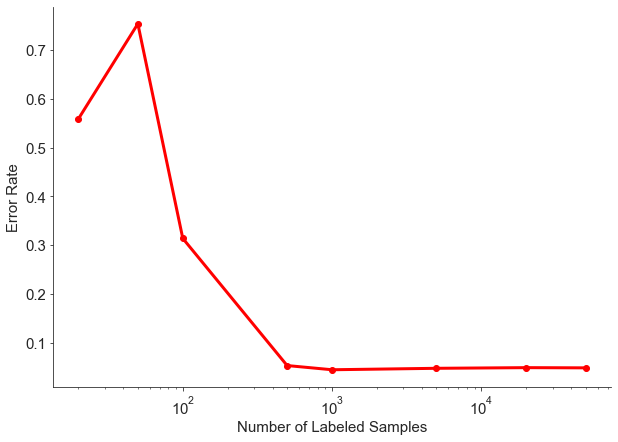

In [43]:
# plot
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style("white")
sns.set_style("ticks")
ax.plot(s_list, mean_error_list, 'ro-', lw=3)
sns.set_palette("pastel")
ax.set_xscale('log')
ax.tick_params(labelsize=15)
ax.set_xlabel("Number of Labeled Samples", fontsize=15)
ax.set_ylabel("Error Rate", fontsize=15)
sns.despine()
plt.show()